# Build XYZ Map
This script takes the output of Process Scans, and combines them into one XYZ map

In [1]:
#@title Settings { run: "auto" }

# SETTINGS
promap_name = 'promap-301'
# promap_name = 'promap-51'

LOCAL = True

if LOCAL:
    data_dir = '/home/jovyan/SharedData'
else:
    bucket = 'lightleaks'
    bucket_folder = "todaysart" #@param ["music_center", "todaysart"] {allow-input: true}
    data_dir = '/tmp/data/'+bucket_folder

with open(data_dir+'/settings.json') as json_file:
    import json
    data = json.load(json_file)
    proj_width = data['projectors'][0]['width']
    proj_height = data['projectors'][0]['height']
    print("Proj size %i x %i" % (proj_width, proj_height))

Proj size 7680 x 1080


In [2]:
# !sudo apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# !sudo apt-get install -y libturbojpeg  libxrender-dev
# !pip install jpeg4py msgpack numpy-indexed

# !rm -rf utils
# !git clone https://github.com/kylemcdonald/python-utils utils
import sys

# Utils is added at this path in docker image:
sys.path.append('/home/jovyan/')

import cv2
from utils.imutil import *
from utils.progress import *
# from utils.show_array import *
from matplotlib import pyplot as plt
from itertools import product
import glob 
from scipy import ndimage
from multiprocessing import Pool, cpu_count
from numba import jit


# !pip install mpld3
# import matplotlib.pyplot as plt, mpld3
%matplotlib inline


['scan-0028']
scan-0028/promap-301
(3456, 5184)
-0.45365223 1.0


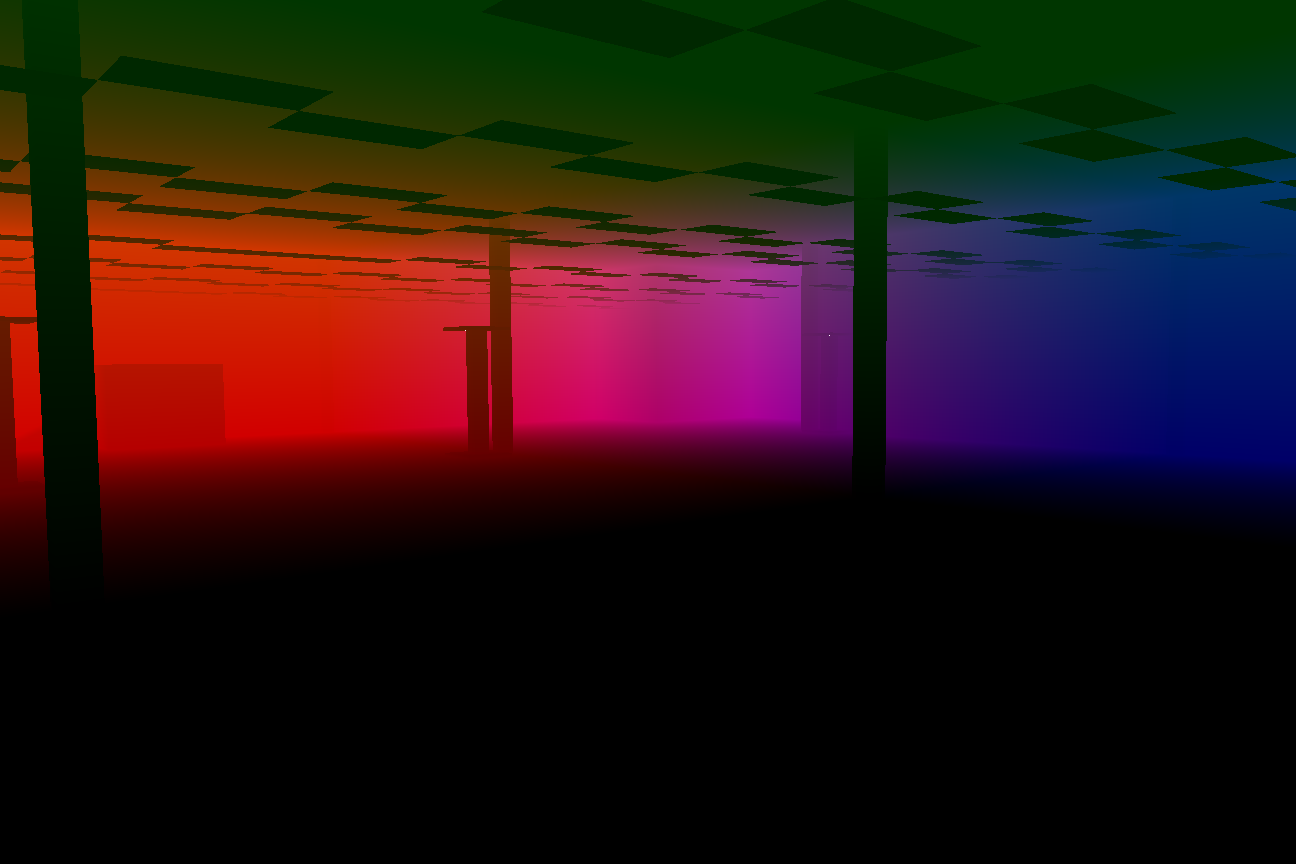

packed before: (17915904, 7)
deduped after: (3297825, 7)
hallelujah


In [47]:
# import re
folders = sorted([f for f in os.listdir(data_dir) if re.match(r'^scan-0028', f)])

# folders = [
#     'scan-2008',
#     'scan-2013',
#     'scan-2017',
#     'scan-2021',
#     'scan-2025',
#     'scan-2030',
#     'scan-2041',
#     'scan-2046',
#     'scan-2326',
#     'scan-2344',
#     'scan-1848',
#     'scan-1851',
#     'scan-1854',
#     'scan-0342'
# ]
print(folders)

def overflow_fix(proMap):
    proMap[(proMap[:,0] >= proj_width) | (proMap[:,1] >= proj_height)] = [0,0]

# rows, cols = camHeight, camWidth
# confidence.shape: rows, cols (float)
# proMap.shape: rows, cols, 2 (int)
# xyzMap.shape: rows, cols, 3 (float)
# cam_index: int
def pack_maps(confidence, proMap, xyzMap, cam_index):
    """ Pack camera confidence, cam projector map and camera xyz map """
    # prepare confidenceFlat
    confidenceFlat = confidence.reshape(-1,1)
    
    # prepare proMapFlat
    proMapFlat = proMap.reshape(( -1, 2))
    overflow_fix(proMapFlat)
    proMapFlat = np.ravel_multi_index(proMapFlat.transpose()[::-1], (proj_height, proj_width)).reshape(-1,1)
    
    # prepare xyzMapFlat
    scale = len(proMap) / len(xyzMap)
    xyzMap = upsample(xyzMap, scale=scale)
    xyzMapFlat = xyzMap.reshape(-1, 3)
    
    # DEBUG STUFF
    # Pack camera index into array
    camIndexFlat = np.full((xyzMapFlat.shape[0],1), cam_index)
    
    # Cam Pixel Index
    camPixelIndex = np.arange(xyzMapFlat.shape[0])[:,np.newaxis]

    # stack and return everything in shape: (rows x cols), 7
    return np.hstack((confidenceFlat, proMapFlat, xyzMapFlat, camIndexFlat, camPixelIndex))


    
def dedupe(packed):
    # get indices sorted by confidence, use ::-1 to put max confidence first
    packedSortedIndices = packed[:,0].argsort()[::-1]
    packedSorted = packed[packedSortedIndices]

    # get unique packedSorted indices
    _, indices = np.unique(packedSorted.transpose()[1], return_index=True)
    return packedSorted[indices]


cam_width = None
cam_height = None

deduped = None
for i, folder in enumerate(folders):
    print(folder+'/'+promap_name)
    confidence = imread(os.path.join(data_dir, folder, promap_name, 'camConfidence.exr'))
    print(confidence.shape)
    proMap = np.load(os.path.join(data_dir, folder, promap_name,'camBinary.npy'))
#     xyzMap = imread(os.path.join(data_dir, folder,'xyzMap.exr'))
    xyzMap = np.fromfile(os.path.join(data_dir, folder, 'camamokXyzMap.raw'), dtype='float32', sep="")
    xyzMap = xyzMap.reshape([864  , 1296 , 4])[:,:,0:3]
    print(np.min(xyzMap), np.max(xyzMap))
    imshow(xyzMap * 255)#, fmt='jpg', zoom=0.5)

    
    cam_width = confidence.shape[1]
    cam_height = confidence.shape[0]
    
    assert len(confidence) > 0
    assert len(proMap) > 0
    assert len(xyzMap) > 0
    
    packed = pack_maps(confidence, proMap, xyzMap, i)
    print('packed before:', packed.shape)
    if deduped is not None:
#         print('deduped before:', deduped.shape)
        packed = np.vstack((packed, deduped))
#         print('packed after:', packed.shape)
    deduped = dedupe(packed)
    print('deduped after:', deduped.shape)

print('hallelujah')


proXyzMap


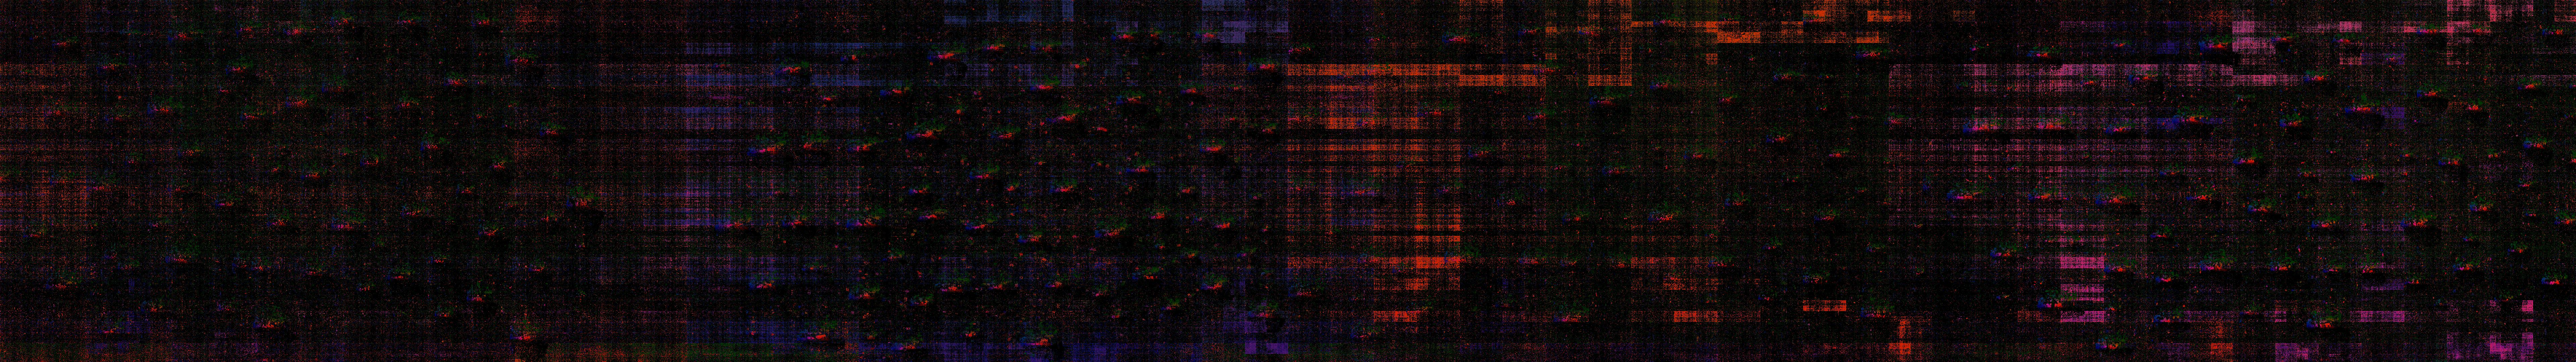

ProConfidence


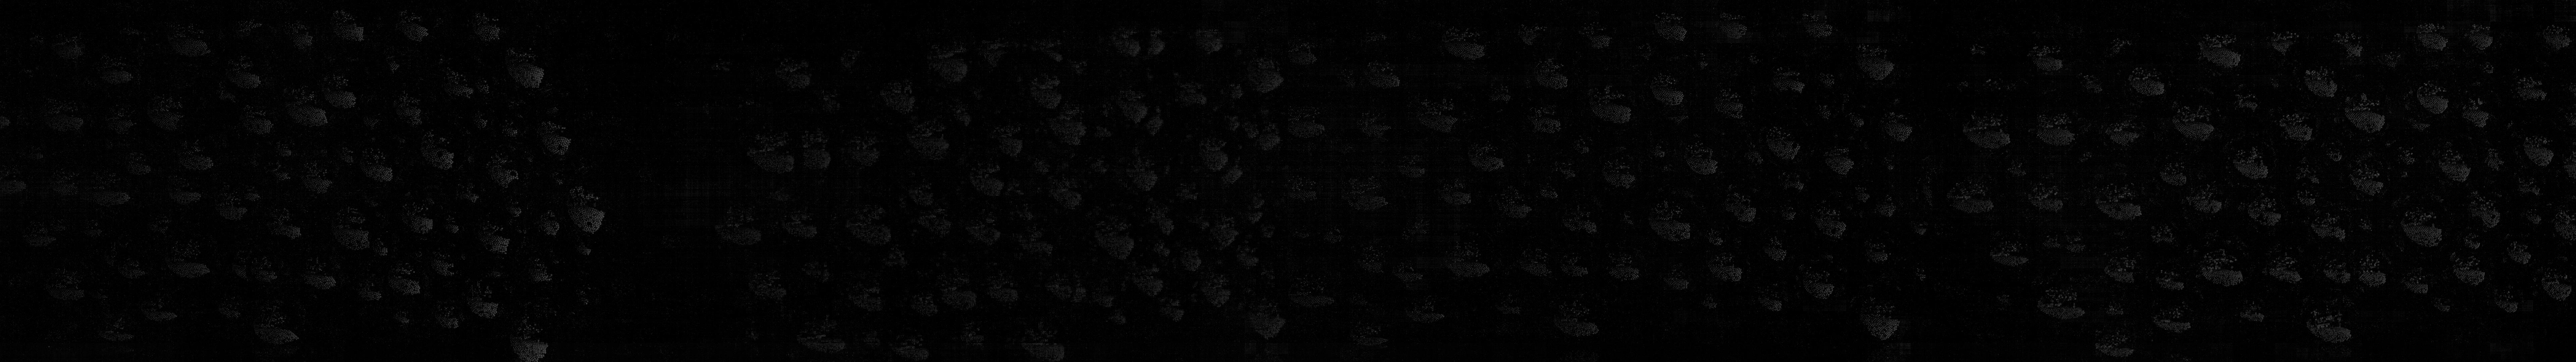

Cam index map


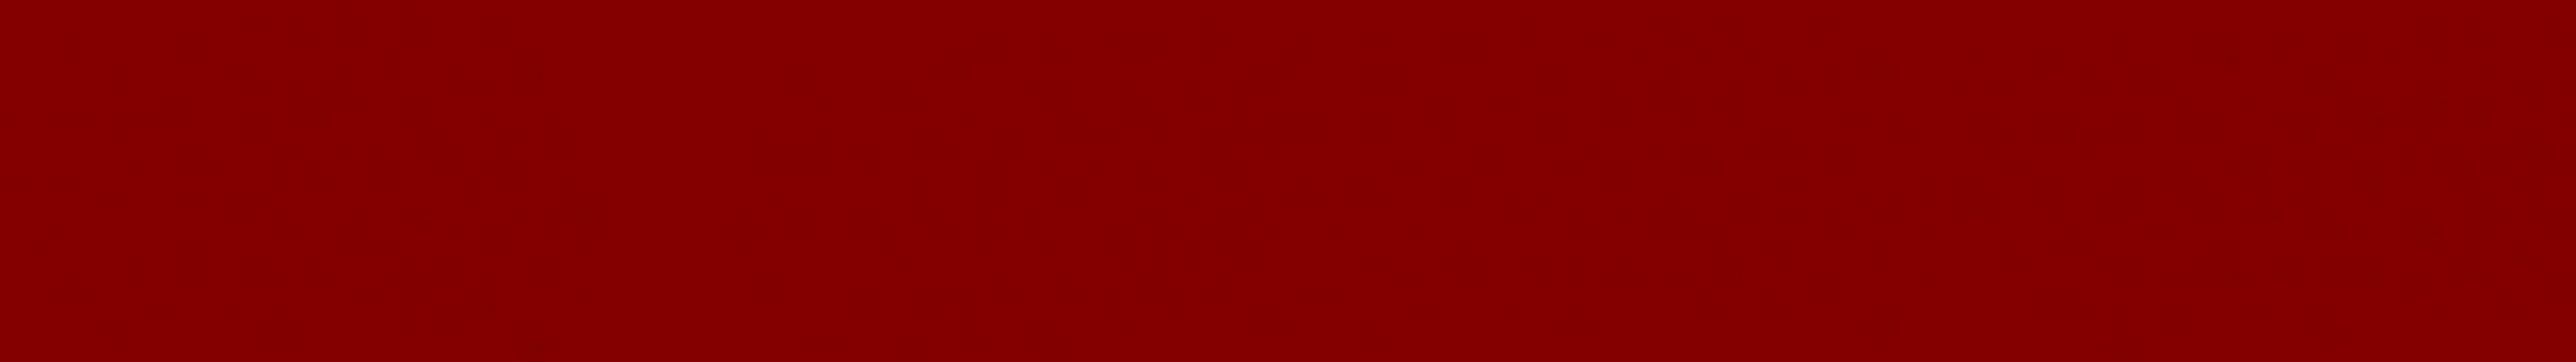

scan-0028


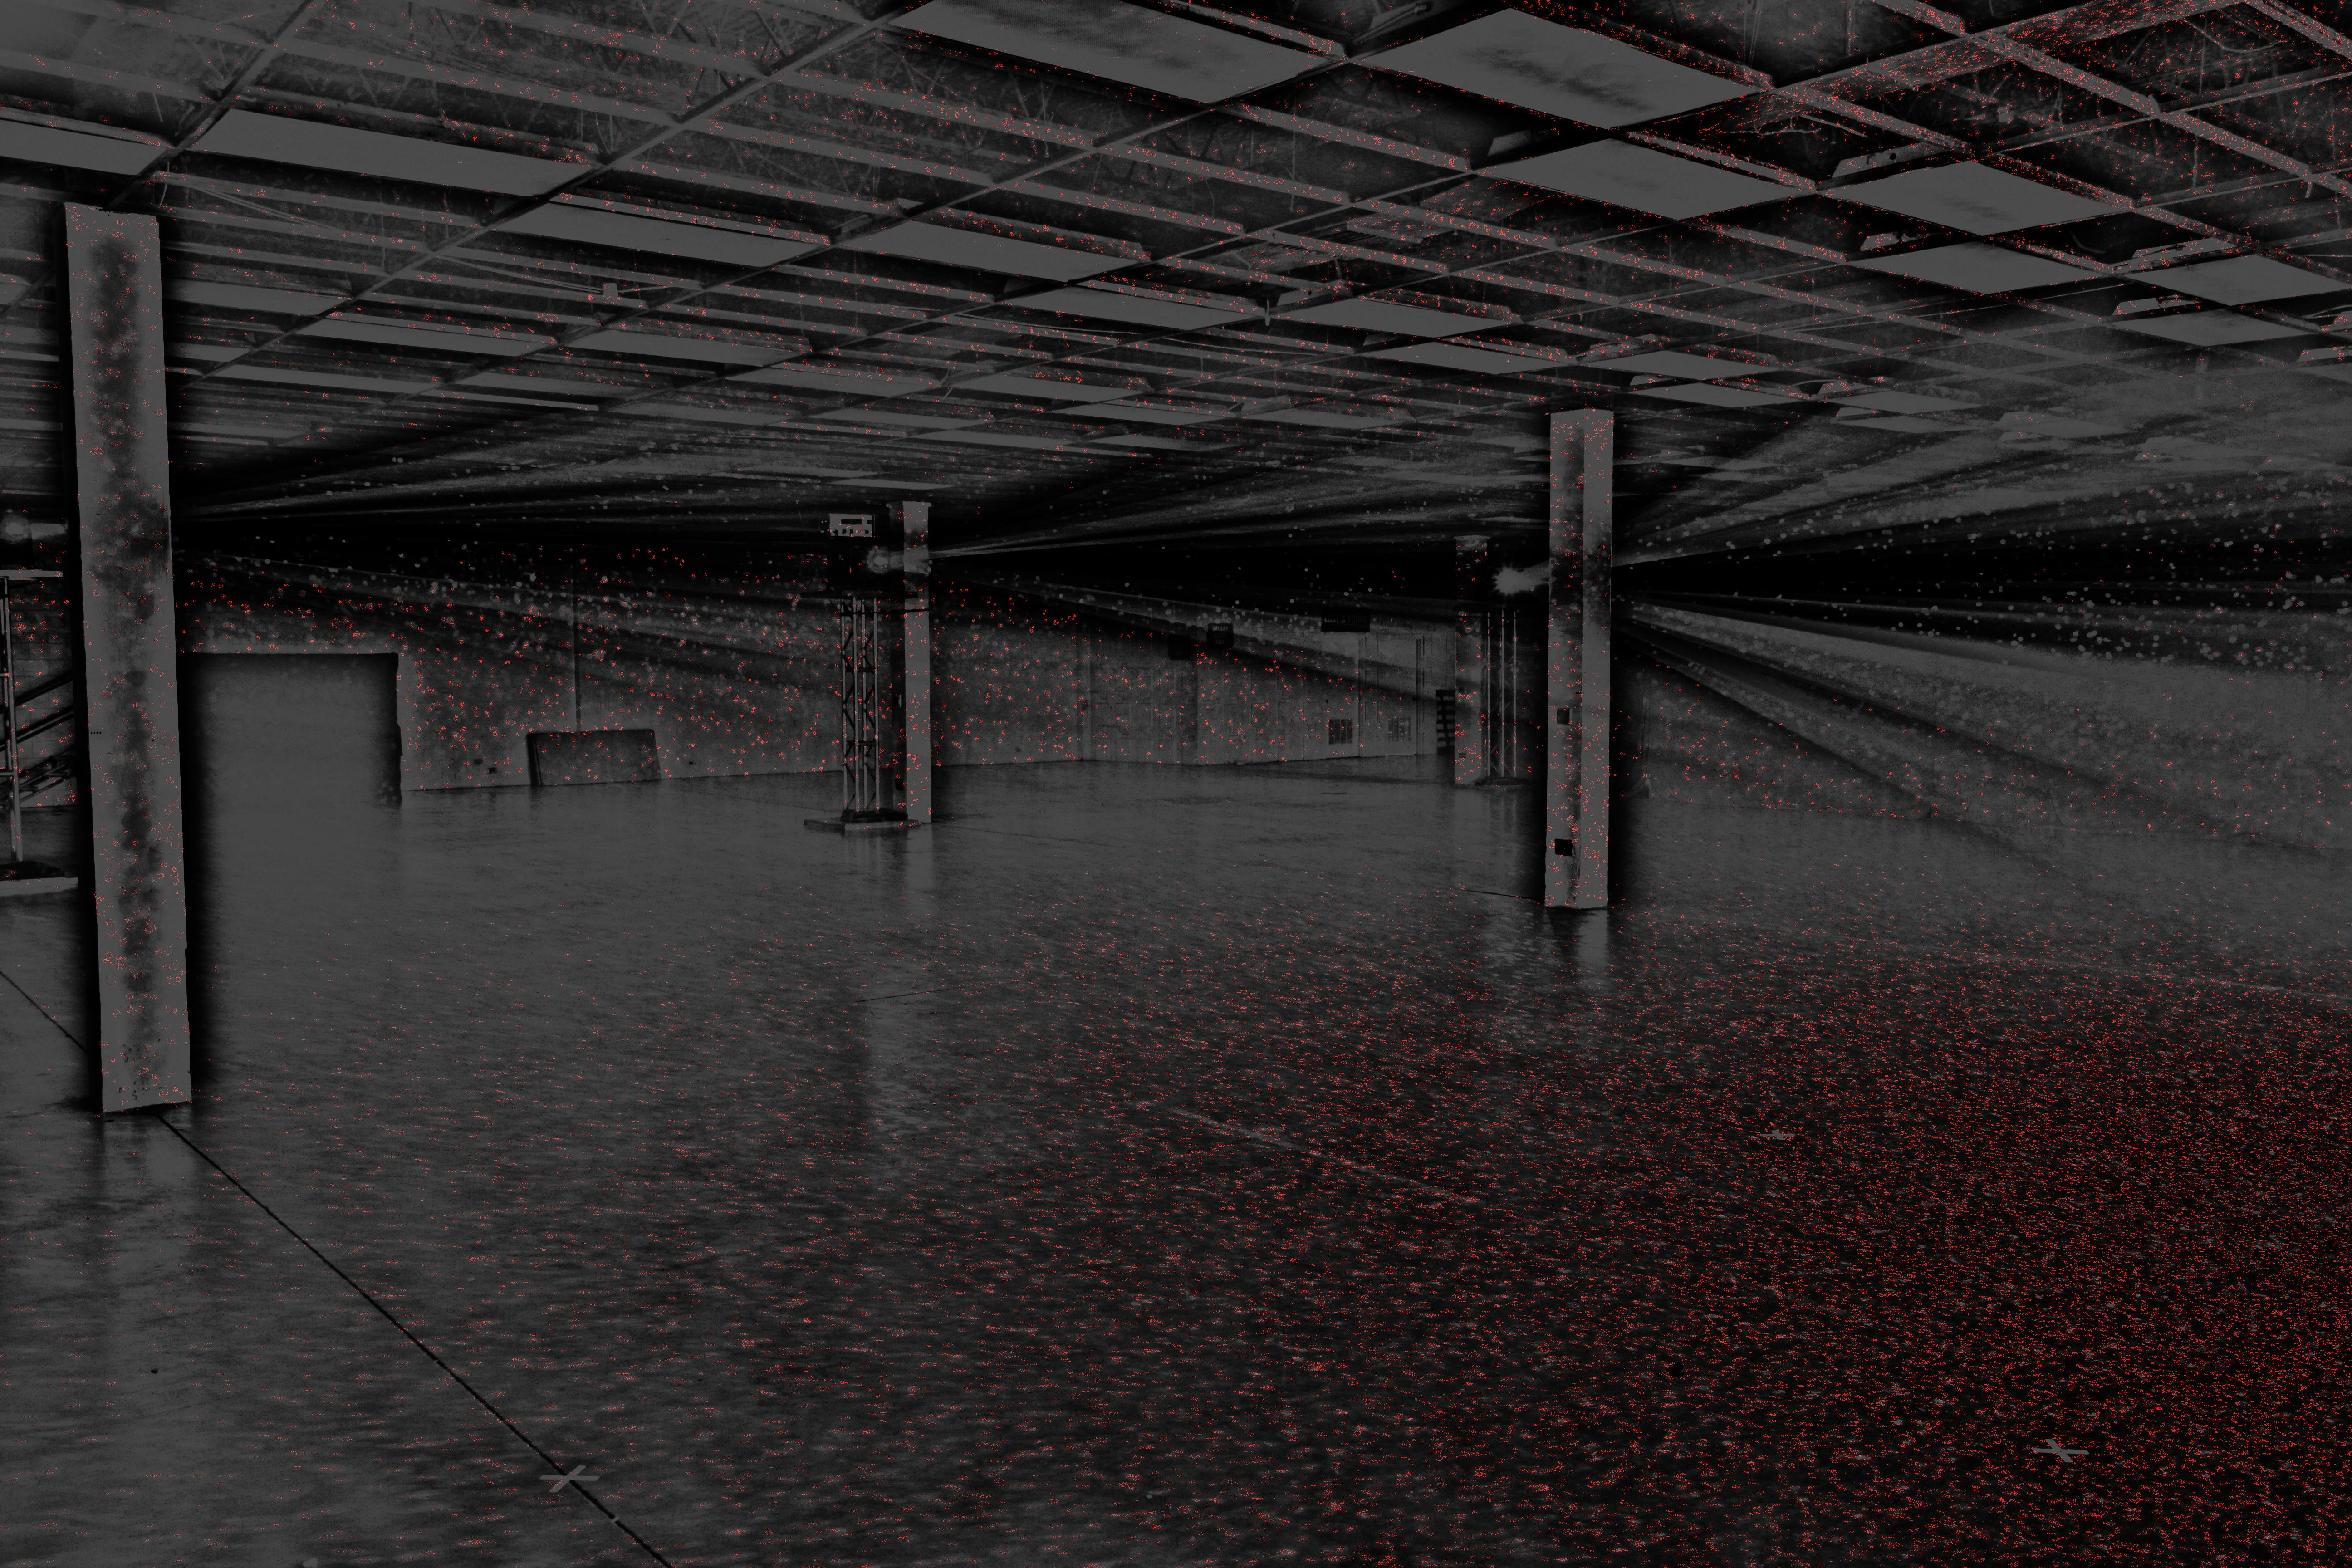

In [48]:
import matplotlib.pyplot as plt

def unpack_maps(packed):
    """ Unpack projector xyz map and projector confidence """
    proXyzMap = np.zeros((proj_height, proj_width, 3))
    proConfidence = np.zeros((proj_height, proj_width, 1))
    camIndex = np.full((proj_height, proj_width, 1), -1)
    camPixelIndex = np.zeros((proj_height, proj_width, 1))
        
    # assign xyzMap values use proMapFlat indices
    proMapFlat = packed[:,1].astype(np.int32)
    proXyzMap.reshape(-1, 3)[proMapFlat] = packed[:,2:5]
    proConfidence.reshape(-1)[proMapFlat] = packed[:,0]

    # DEBUG STUFF
    camIndex.reshape(-1)[proMapFlat] = packed[:,5]
    camPixelIndex.reshape(-1)[proMapFlat] = packed[:,6].astype(np.uint64)
    
    
    return proXyzMap, proConfidence, camIndex, camPixelIndex

proXyzMap, proConfidence, camIndexMap, camPixelIndex = unpack_maps(deduped)
print("proXyzMap")
imshow(proXyzMap*255, fmt='jpg')
print("ProConfidence")
imshow(proConfidence*255, fmt='jpg')

print("Cam index map")
camIndexMapColored = np.copy(camIndexMap)
camIndexMapColored[ proConfidence < 0.1 ] = -1
camIndexMapColored = camIndexMapColored * 255 /  (camIndexMap.max()+1)
camIndexMapColored = cv2.applyColorMap(camIndexMapColored.astype(np.uint8), cv2.COLORMAP_JET)
imshow(camIndexMapColored, fmt='jpg')

# print(camPixelIndex, camPixelIndex.shape)

for i, folder in enumerate(folders):
    print(folder)
    debug = np.zeros((cam_height, cam_width))
    
    indicies = camPixelIndex.reshape(-1)
    indicies = camPixelIndex[ camIndexMap == i ].astype(np.uint64)
    debug.reshape(-1)[indicies] = 255 # * confidence.reshape(-1)[indicies]
    
#     debug = cv2.equalizeHist(debug.astype(np.uint8))
    confidence = imread(os.path.join(data_dir, folder, promap_name, 'camConfidence.exr'))
    debug[confidence < 0.1] = 0.0

    ref = imread(os.path.join(data_dir, folder, promap_name,'referenceImage.jpg')) * 0.3
    ref = np.stack((ref,)*3, axis=-1)
    ref[:,:,0] += debug
#     ref[:,:,1] += debug
#     ref[:,:,2] += debug

    imshow(ref, fmt='jpg', zoom=0.5)


# print(u, c)


In [14]:
debug_out_path = '../SharedData/BuildXYZ-%s/' % promap_name
if not os.path.exists(debug_out_path):
    os.makedirs(debug_out_path)


projMask = imread(os.path.join(data_dir, 'mask-0.png')).mean(axis=2) / 255
proConfidenceMasked = proConfidence * projMask[:,:,np.newaxis]
imwrite(debug_out_path+'confidenceMap-0.exr', proConfidenceMasked.astype(np.float32))
imwrite(debug_out_path+'xyzMap-0.exr', proXyzMap.astype(np.float32))
imwrite(debug_out_path+'camIndexMap.png', camIndexMap)
imwrite(debug_out_path+'camIndexMapColored.png', camIndexMapColored)

with open(debug_out_path+"BuildXYZOutput.txt", "w") as text_file:
    def t(text):
        text_file.write("%s\n" % text)
        print(text)
        
    t("Scans used:")
    for s in folders:
        t("\t%s" % s)
    t("\nProMap folder used: %s" % promap_name)
    t("Resolution: %ix%i" % (proj_width, proj_height))
    
    threshold = 0.05
    t("\nCoverage (threshold %.2f):" % threshold)
    masked_camIndexMap = np.copy(camIndexMap)
    masked_camIndexMap[ proConfidence < threshold ] = -1
    u, c = np.unique(masked_camIndexMap, return_counts=True)
    for _u,_c in zip(u,c):
        if _u != -1:
            t("\tScan %i (%s): %.2f%% (%i)" % (_u, folders[int(_u)], 100*_c / sum(c), _c))
        else:
            t("\tNo scan: %.2f%% (%i)" % (100*_c / sum(c), _c))
    


# imwrite('../SharedData/confidenceMap-0-'+folders[0]+'.exr', proConfidenceMasked.astype(np.float32))
# imwrite('../SharedData/xyzMap-0-'+folders[0]+'.exr', proXyzMap.astype(np.float32))

Scans used:
	scan-2017

ProMap folder used: promap-301
Resolution: 3840x2160

Coverage (threshold 0.05):
	No scan: 96.81% (8029511)
	Scan 0 (scan-2017): 3.19% (264889)


# 

In [ ]:
def calculate_beam_angle():

    beam_dir_map = np.zeros((proj_height, proj_width, 3))
    
    projector_position = np.asarray([ 0, 1, 0 ])
    
    hit_area = np.asarray([
        [ 0, 0, 0],
        [ 0.1, 0, 0],
        [ 0, 0.1, 0]
    ])

    for x in range(proj_width):
        for y in range(proj_height):
            if proConfidenceMasked[y,x] > 0:
                hit_point = hit_area[0]
                hit_point += (hit_area[1] - hit_area[0]) * (x / proj_width)
                hit_point += (hit_area[2] - hit_area[0]) * (y / proj_height)
#                 print(hit_point)
#                 print(x,y)
#                 print(proXyzMap[y,x])
#                 print(proConfidenceMasked[y,x])
                
                in_vec = projector_position - hit_point
                out_vec = hit_point - proXyzMap[y,x]
#                 print(out_vec)
                beam_dir_map[y, x] = out_vec
                

    return beam_dir_map

beam_dir_map = calculate_beam_angle()

imshow(np.abs(beam_dir_map)*255, fmt='jpg')
